In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("../data/mental_health_reddit_with_sentiment_and_topics.csv")
df.shape, df.columns


((50000, 7),
 Index(['clean_text', 'mental_health_topic', 'created_utc', 'nsfw',
        'word_count', 'sentiment_score', 'dominant_topic'],
       dtype='object'))

In [3]:
df["created_datetime"] = pd.to_datetime(df["created_utc"], unit="s")
df["year_month"] = df["created_datetime"].dt.to_period("M")
df[["created_datetime", "year_month"]].head()


,created_datetime,year_month
0,2022-01-09 21:28:03,2022-01
1,2021-11-27 05:20:50,2021-11
2,2022-10-05 23:12:56,2022-10
3,2021-03-13 02:04:37,2021-03
4,2019-06-05 21:12:44,2019-06


In [4]:
high_risk_terms = [
    "suicidal", "suicide", "kill myself", "end my life",
    "can't go on", "dont want to live", "tired of living",
    "self harm", "self-harm", "cutting", "hurt myself"
]

def has_high_risk_phrase(text):
    text = str(text).lower()
    return any(term in text for term in high_risk_terms)

df["high_risk_keyword"] = df["clean_text"].apply(has_high_risk_phrase)
df["high_risk_keyword"].value_counts()


high_risk_keyword
False    43886
True      6114
Name: count, dtype: int64

In [5]:
# Strongly negative sentiment threshold
NEG_THRESHOLD = -0.6

df["high_risk_sentiment"] = df["sentiment_score"] <= NEG_THRESHOLD

# Final combined flag
df["high_risk_flag"] = df["high_risk_keyword"] | df["high_risk_sentiment"]

df[["high_risk_keyword", "high_risk_sentiment", "high_risk_flag"]].mean()


high_risk_keyword      0.12228
high_risk_sentiment    0.48828
high_risk_flag         0.52374
dtype: float64

In [6]:
risk_rate = df["high_risk_flag"].mean()
print(f"Estimated high-risk post proportion: {risk_rate:.3%}")


Estimated high-risk post proportion: 52.374%


In [7]:
topic_risk = (
    df.groupby("mental_health_topic")["high_risk_flag"]
      .mean()
      .sort_values(ascending=False)
)

topic_risk.head(15)


mental_health_topic
depression       0.614740
mentalillness    0.566251
anxiety          0.524047
bpd              0.503339
bipolar          0.372235
schizophrenia    0.300000
Name: high_risk_flag, dtype: float64

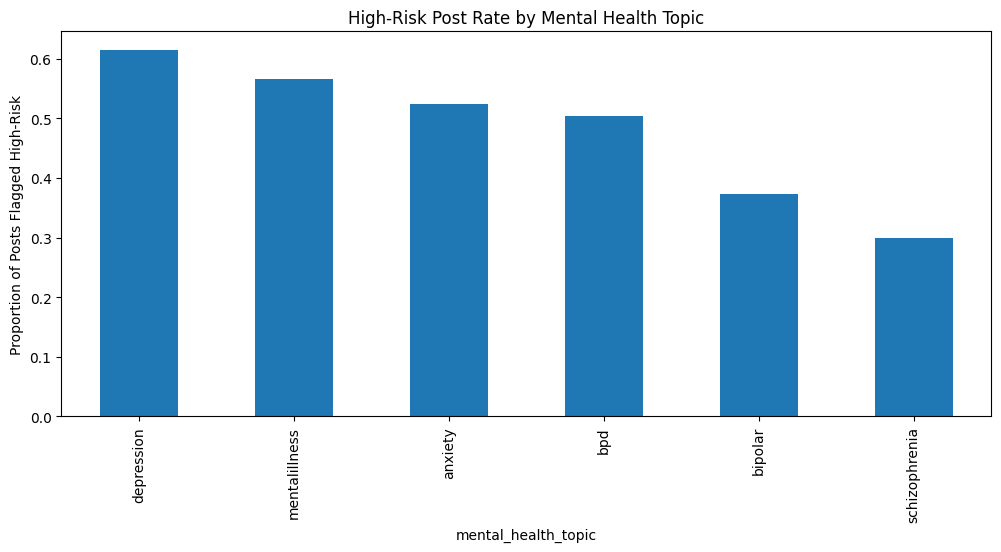

In [8]:
topic_risk.head(15).plot(
    kind="bar",
    figsize=(12, 5),
    title="High-Risk Post Rate by Mental Health Topic"
)
plt.ylabel("Proportion of Posts Flagged High-Risk")
plt.show()


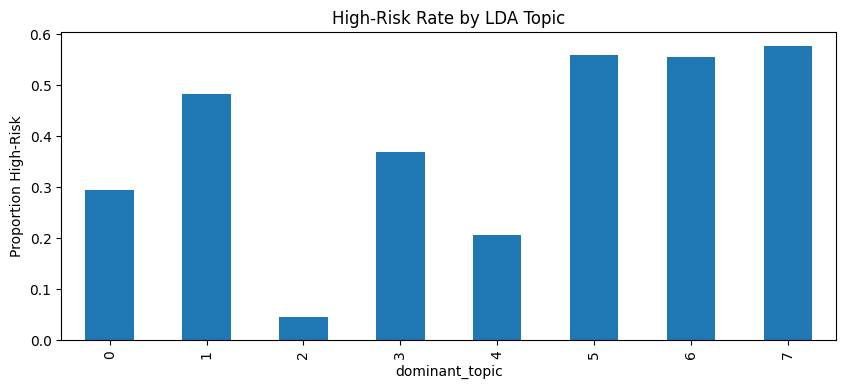

In [9]:
if "dominant_topic" in df.columns:
    lda_risk = (
        df.groupby("dominant_topic")["high_risk_flag"]
          .mean()
          .sort_index()
    )
    lda_risk.plot(
        kind="bar",
        figsize=(10, 4),
        title="High-Risk Rate by LDA Topic"
    )
    plt.ylabel("Proportion High-Risk")
    plt.show()


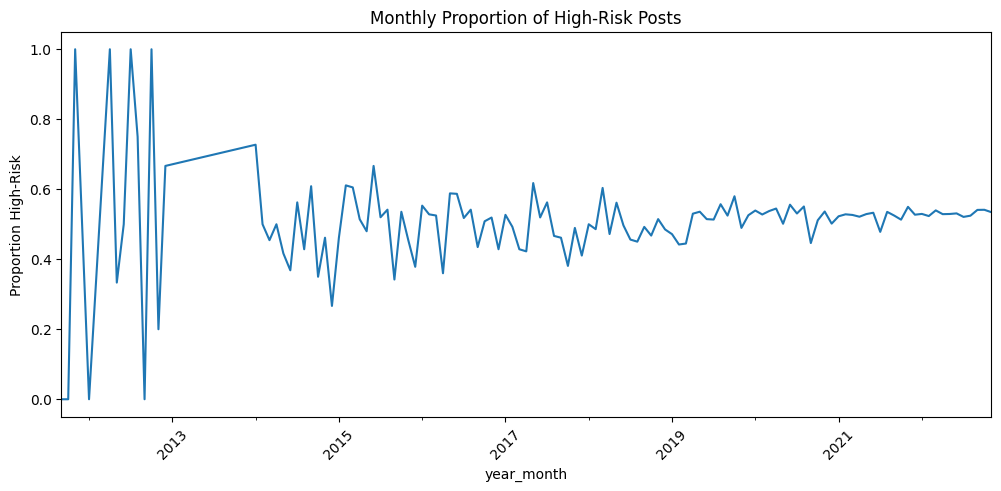

In [10]:
monthly_risk = (
    df.groupby("year_month")["high_risk_flag"]
      .mean()
)

monthly_risk.plot(
    figsize=(12, 5),
    title="Monthly Proportion of High-Risk Posts"
)
plt.ylabel("Proportion High-Risk")
plt.xticks(rotation=45)
plt.show()


In [11]:
examples = (
    df[df["high_risk_flag"]]
    .sort_values("sentiment_score")
    [["clean_text", "sentiment_score", "mental_health_topic"]]
    .head(15)
)

pd.set_option("display.max_colwidth", 200)
examples


,clean_text,sentiment_score,mental_health_topic
17226,i want to fucking kill myself i want to fucking kill myself i want to fucking kill myselfi want to fucking kill myself i want to fucking kill myselfi want to fucking kill myself i want to fucking ...,-1.0000,depression
38483,symptoms of anxiety anxiety symptoms when you want to overcome anxiety focusing on specific symptoms doesnt help having symptoms doesnt mean you have problems to focus on you have one anxiety so a...,-1.0000,anxiety
23188,i really need get this off my chest and let out my frustrated and anger and rage please understand my situation and my statement im not on here for attention and sympathy and followers im only on ...,-0.9999,depression
8347,i’m feeling heavily suicidal i’m going to break soon i feel so alone i don’t really have any friends at all i have a caring compassionate girlfriend the best thing that could ever happen to me pul...,-0.9999,mentalillness
10540,i am angry that my mother hi gang working through having bpd as a concept still kinda new to me just found out i was one of the lucky in the last few months anyway with the fervor of a new convert...,-0.9998,bpd
19551,really struggling with violent and disturbing thoughts cw suicide ive been trying really hard to get help for more the better part of a year now and i havent really been successful i am on a cockt...,-0.9998,bpd
5819,am i mentally ill is this depression or what i often hate myself like a lot today and yesterday were the only days i’ve felt okay i want to say beforehand that i do have social anxiety anxiety and...,-0.9998,depression
8190,i just want to get it off my chest right now im financially stuck in a place i really dont want to be i never really thought that i was abused growing up i still dont know if anything that happene...,-0.9998,depression
9936,what would you do if your partner sent you this letter would it go well or no ive been waiting to tell you my thoughts until you had the tools to understand and respond appropriately but its start...,-0.9998,bpd
44647,bpd has destroyed my family hello reddit this is my first post ever it will be a throwaway account but i needed to post this i just turned last week and have seemed to finally connected the dots w...,-0.9998,bpd


In [12]:
summary_topic_risk = topic_risk.reset_index()
summary_topic_risk.columns = ["mental_health_topic", "high_risk_rate"]

summary_topic_risk.to_csv(
    "../data/summary_high_risk_by_topic.csv",
    index=False
)

print("✅ Saved summary_high_risk_by_topic.csv (safe small file)")


✅ Saved summary_high_risk_by_topic.csv (safe small file)
